# L1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request
from scipy.spatial.distance import hamming
from scipy.stats import kendalltau
from scipy.stats import mode
from tqdm import tqdm

%matplotlib inline

## P1
Zapoznaj się z algorytmem symulowanego wyżarzania (ang. Simulated Annealing, SA)
wykonując skrypt Pythona umieszczony w materiałach do wykładu. Przedstawia on
zastosowanie algorytmu SA do rozwiązywania problemu Quadratic Assignment Problem
(QAP) omówionego na wykładzie.
Skrypt z wykładu:

Popularne instancje QAP wraz z dokładnym minimum funkcji celu 
* Nug12 12 578 (OPT) (12,7,9,3,4,8,11,1,5,6,10,2) 
* Nug14 14 1014 (OPT) (9,8,13,2,1,11,7,14,3,4,12,5,6,10)
* Nug15 15 1150 (OPT) (1,2,13,8,9,4,3,14,7,11,10,15,6,5,12)
* Nug16a 16 1610 (OPT) (9,14,2,15,16,3,10,12,8,11,6,5,7,1,4,13) 
* Nug16b 16 1240 (OPT) (16,12,13,8,4,2,9,11,15,10,7,3,14,6,1,5) 
* Nug17 17 1732 (OPT) (16,15,2,14,9,11,8,12,10,3,4,1,7,6,13,17,5) 
* Nug18 18 1930 (OPT) (10,3,14,2,18,6,7,12,15,4,5,1,11,8,17,13,9,16) 
* Nug20 20 2570 (OPT) (18,14,10,3,9,4,2,12,11,16,19,15,20,8,13,17,5,7,1,6) 
* Nug21 21 2438 (OPT) (4,21,3,9,13,2,5,14,18,11,16,10,6,15,20,19,8,7,1,12,17) 
* Nug22 22 3596 (OPT) (2,21,9,10,7,3,1,19,8,20,17,5,13,6,12,16,11,22,18,14,15) 
* Nug24 24 3488 (OPT) (17,8,11,23,4,20,15,19,22,18,3,14,1,10,7,9,16,21,24,12,6,13,5,2) 
* Nug25 25 3744 (OPT) (5,11,20,15,22,2,25,8,9,1,18,16,3,6,19,24,21,14,7,10,17,12,4,23,13) 


* Nug27 27 5234 (OPT) (23,18,3,1,27,17,5,12,7,15,4,26,8,19,20,2,24,21,14,10,9,13,22,25,6,16,11) 
* Nug28 28 5166 (OPT) (18,21,9,1,28,20,11,3,13,12,10,19,14,22,15,2,25,16,4,23,7,17,24,26,5,27,8,6) 
* Nug30 30 6124 (OPT) (5 12 6 13 2 21 26 24 10 9 29 28 17 1 8 7 19 25 23 22 11 16 30 4 15 18 27 3 14 20)

In [2]:
def read_qap(name='nug12'):
    QAP_INSTANCE_URL = f'http://anjos.mgi.polymtl.ca/qaplib/data.d/{name}.dat'
    qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    print('Problem size: %d' % n)

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Flow matrix:\n', A)

    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Distance matrix:\n', B)
    return n,A,B

In [3]:
def qap_objective_function(p,n,A,B):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [4]:
p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
n,A,B = read_qap('nug12')
print(qap_objective_function(p,n,A,B), p)

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

In [4]:
def random_solution(n,A,B):
    t0 = time.time()

    T = 1000000

    permutations = np.empty((T, n), dtype=np.int64)
    costs = np.zeros(T)
    for i in range(T):
        permutations[i, :] = np.random.permutation(n)
        costs[i] = qap_objective_function(permutations[i, :],n,A,B)

    print(time.time() - t0)

    p = permutations[costs.argmin(), :]
    print(qap_objective_function(p,n,A,B), p)
    return permutations,costs

89.40492796897888
600.0 [ 3  7 10  2 11  6  8  0  4  5  9  1]


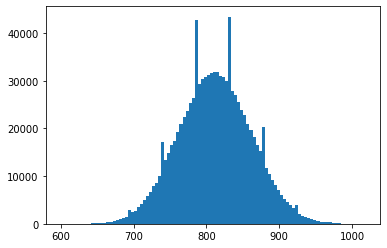

812.008148 49.69322599318841


In [6]:
permutations,costs = random_solution(n,A,B)
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

In [5]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [6]:
def simulated_annealing(n,A,B,T=500000,radius=1,alpha=1.0):
    t0 = time.time()

    p = np.random.permutation(n)
    p_cost = qap_objective_function(p,n,A,B)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q,n,A,B)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost

    print(time.time() - t0, costs.min())
    return costs,p

62.124924182891846 578.0


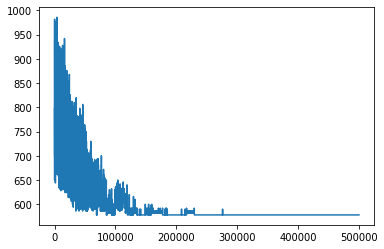

In [9]:
costs,p = simulated_annealing(n,A,B)
plt.figure()
plt.plot(costs)
plt.show()

a) Postaraj się dobrać parametry algorytmu SA umożliwiające rozwiązywanie problemu
QAP dla kilku innych instancji.

Problem size: 14
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.  1.  0.  2.  5.]
 [ 1.  2.  2.  1.  0.  3.  5.  5.  5.  1.  0.  3.  0.  5.]
 [ 0.  2.  0.  1.  3.  0.

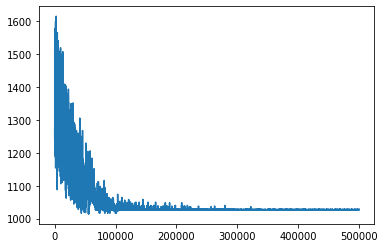

In [18]:
n,A,B = read_qap(name='nug14')
goal = 1014
opt_solution = (9,8,13,2,1,11,7,14,3,4,12,5,6,10)
costs,p = simulated_annealing(n,A,B,T=500000,radius=1,alpha=1.0)
plt.figure()
plt.plot(costs)
plt.show()

Problem size: 15
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.  0.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.

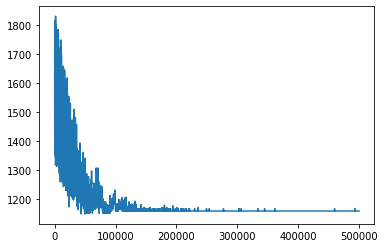

In [20]:
n,A,B = read_qap(name='nug15')
goal = 1150 
opt_solution = (1,2,13,8,9,4,3,14,7,11,10,15,6,5,12)
costs,p = simulated_annealing(n,A,B,T=500000,radius=1,alpha=1.0)
plt.figure()
plt.plot(costs)
plt.show()

Problem size: 18
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5. 4.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6. 5.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3.]
 [3. 4. 5. 6. 7. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2.]
 [4. 3. 4. 5. 6. 3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1.]


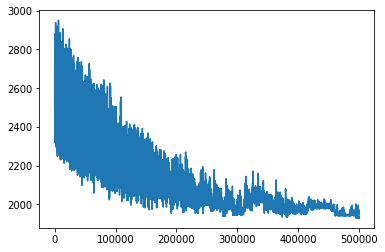

In [22]:
n,A,B = read_qap(name='nug18')
goal = 1930 
opt_solution = (10,3,14,2,18,6,7,12,15,4,5,1,11,8,17,13,9,16)
costs,p = simulated_annealing(n,A,B,T=500000,radius=1,alpha=0.2)
plt.figure()
plt.plot(costs)
plt.show()

Problem size: 24
Flow matrix:
 [[0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 7. 3. 4. 5. 6. 7. 8.]
 [1. 0. 1. 2. 3. 4. 2. 1. 2. 3. 4. 5. 3. 2. 3. 4. 5. 6. 4. 3. 4. 5. 6. 7.]
 [2. 1. 0. 1. 2. 3. 3. 2. 1. 2. 3. 4. 4. 3. 2. 3. 4. 5. 5. 4. 3. 4. 5. 6.]
 [3. 2. 1. 0. 1. 2. 4. 3. 2. 1. 2. 3. 5. 4. 3. 2. 3. 4. 6. 5. 4. 3. 4. 5.]
 [4. 3. 2. 1. 0. 1. 5. 4. 3. 2. 1. 2. 6. 5. 4. 3. 2. 3. 7. 6. 5. 4. 3. 4.]
 [5. 4. 3. 2. 1. 0. 6. 5. 4. 3. 2. 1. 7. 6. 5. 4. 3. 2. 8. 7. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 7.]
 [2. 1. 2. 3. 4. 5. 1. 0. 1. 2. 3. 4. 2. 1. 2. 3. 4. 5. 3. 2. 3. 4. 5. 6.]
 [3. 2. 1. 2. 3. 4. 2. 1. 0. 1. 2. 3. 3. 2. 1. 2. 3. 4. 4. 3. 2. 3. 4. 5.]
 [4. 3. 2. 1. 2. 3. 3. 2. 1. 0. 1. 2. 4. 3. 2. 1. 2. 3. 5. 4. 3. 2. 3. 4.]
 [5. 4. 3. 2. 1. 2. 4. 3. 2. 1. 0. 1. 5. 4. 3. 2. 1. 2. 6. 5. 4. 3. 2. 3.]
 [6. 5. 4. 3. 2. 1. 5. 4. 3. 2. 1. 0. 6. 5. 4. 3. 2. 1. 7. 6. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 7. 1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5

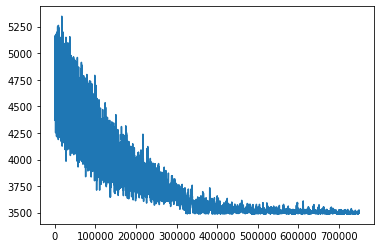

In [27]:
n,A,B = read_qap(name='nug24')
goal = 3488 
opt_solution = (17,8,11,23,4,20,15,19,22,18,3,14,1,10,7,9,16,21,24,12,6,13,5,2)
costs,p = simulated_annealing(n,A,B,T=750000,radius=1,alpha=0.2)
plt.figure()
plt.plot(costs)
plt.show()

b) Histogram w skrypcie pokazuje jaki jest rozkład wartości funkcji celu dla rozwiązań
generowanych losowo. Zrób podobny histogram dla rozwiązań generowanych algorytmem
SA (dla ustalonej instancji QAP i ustalonych parametrów algorytmu). Będzie to wymagać
wielu uruchomień algorytmu i zapewne długich obliczeń. 

In [111]:
costs = []
N = 100
n,A,B = read_qap(name='nug12')
for i in range(N):
    if i and not (i%10):
        print(f'{i} solutions found')
    cost,p = simulated_annealing(n,A,B,T=50000,radius=1,alpha=0.2)
    costs.append(cost.min())

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

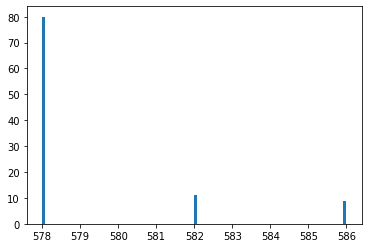

579.16 2.4848339984795755


In [113]:
costs = np.array(costs)
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

Problem size: 15
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.  0.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.

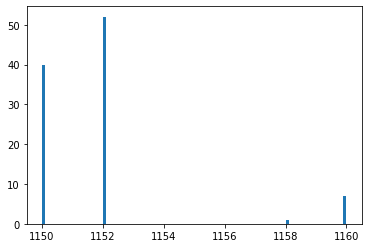

1151.82 2.5313237643572983


In [114]:
costs = []
N = 100
n,A,B = read_qap(name='nug15')
for i in range(N):
    if i and not (i%10):
        print(f'{i} solutions found')
    cost,p = simulated_annealing(n,A,B,T=50000,radius=1,alpha=0.2)
    costs.append(cost.min())
costs = np.array(costs)
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

c) Sprawdź ile jest "sukcesów" (rozwiązanie q lepsze niż rozwiązanie p) i "akceptowanych
porażek" (rozwiązanie q gorsze niż rozwiązanie p, ale zaakceptowane) w kolejnych
iteracjach algorytmu SA (w miarę upływu czasu, "sukcesy" i "akceptowalne porażki" są
coraz rzadsze) dla kilku wybranych ustawień parametrów algorytmu. Zilustruj to zjawisko
wykresem. 

Problem size: 14
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.  1.  0.  2.  5.]
 [ 1.  2.  2.  1.  0.  3.  5.  5.  5.  1.  0.  3.  0.  5.]
 [ 0.  2.  0.  1.  3.  0.

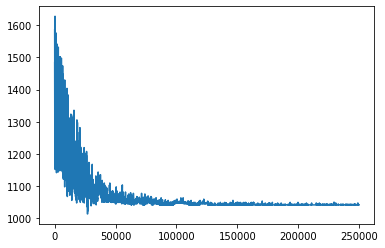

In [39]:
n,A,B = read_qap(name='nug14')
T=250000
radius=1
alpha=1.0
t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p,n,A,B)
costs = np.zeros(T)
c1,c2=[],[]
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q,n,A,B)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
        c1.append(t)
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
        c2.append(t)
    costs[t] = p_cost

print(time.time() - t0, costs.min())
goal = 1014
opt_solution = (9,8,13,2,1,11,7,14,3,4,12,5,6,10)
costs,p,c1,c2 = simulated_annealing_(n,A,B,T=250000,radius=1,alpha=1.0)

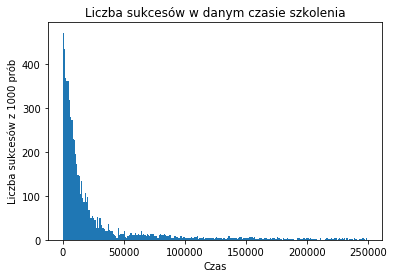

In [46]:
plt.figure()
plt.hist(c1, bins=250)
plt.title('Liczba sukcesów w danym czasie szkolenia')
plt.xlabel('Czas')
plt.ylabel('Liczba sukcesów z 1000 prób')
plt.show()

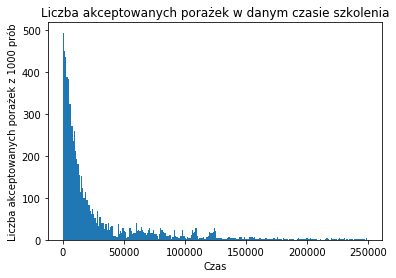

In [47]:
plt.figure()
plt.hist(c2, bins=250)
plt.title('Liczba akceptowanych porażek w danym czasie szkolenia')
plt.xlabel('Czas')
plt.ylabel('Liczba akceptowanych porażek z 1000 prób')
plt.show()

d) Jak można mierzyć odległość między permutacjami? Sprawdź jaka jest zależność
między zmianami wartości funkcji celu f(p) - f(q) w sukcesach, a odległością między
permutacjami p i q. Zilustruj to wykresem. 


In [28]:
n,A,B = read_qap(name='nug14')
T=500000
radius=20
alpha=0.2
t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p,n,A,B)
costs = np.zeros(T)
improves, hamming_dists, kendalltau_dists = [],[],[]
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q,n,A,B)
    if(q_cost < p_cost):
        improves.append(p_cost-q_cost)
        hamming_dists.append(hamming(p,q))
        kendalltau_dists.append(kendalltau(p,q))
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

Problem size: 14
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.  1.  0.  2.  5.]
 [ 1.  2.  2.  1.  0.  3.  5.  5.  5.  1.  0.  3.  0.  5.]
 [ 0.  2.  0.  1.  3.  0.

In [29]:
def standarize(data):
    data = np.array(data)
    data = (data-np.min(data))/(np.max(data)-np.min(data))
    return data

Text(0.5, 1.0, 'Hamming dist')

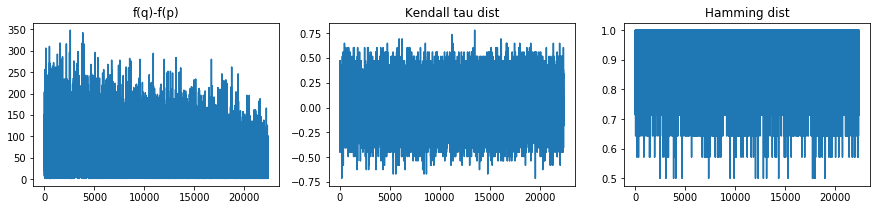

In [30]:
kendalltau_dists = np.array(kendalltau_dists)[:,0]

# improves = standarize(improves)
# hamming_dists = standarize(hamming_dists)
# kendalltau_dists = standarize(kendalltau_dists)

f,axs = plt.subplots(1,3,figsize=(15,3))
axs[0].plot(improves,label='f(q)-f(p)')
axs[0].set_title('f(q)-f(p)')
axs[1].plot(kendalltau_dists,label='Kendall tau dist')
axs[1].set_title('Kendall tau dist')
axs[2].plot(hamming_dists,label='Hamming dist')
axs[2].set_title('Hamming dist')

e) Spróbuj ulepszyć algorytm proponując inny warunek akceptowania porażki. 

In [110]:
def simulated_annealing2(n,A,B,T=500000,radius=1,alpha=1.0):
    t0 = time.time()

    p = np.random.permutation(n)
    p_cost = qap_objective_function(p,n,A,B)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q,n,A,B)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        # T function
        elif(np.random.rand() < np.exp(- alpha * 50 * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost

    print(time.time() - t0, costs.min())
    return costs,p

Problem size: 24
Flow matrix:
 [[0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 7. 3. 4. 5. 6. 7. 8.]
 [1. 0. 1. 2. 3. 4. 2. 1. 2. 3. 4. 5. 3. 2. 3. 4. 5. 6. 4. 3. 4. 5. 6. 7.]
 [2. 1. 0. 1. 2. 3. 3. 2. 1. 2. 3. 4. 4. 3. 2. 3. 4. 5. 5. 4. 3. 4. 5. 6.]
 [3. 2. 1. 0. 1. 2. 4. 3. 2. 1. 2. 3. 5. 4. 3. 2. 3. 4. 6. 5. 4. 3. 4. 5.]
 [4. 3. 2. 1. 0. 1. 5. 4. 3. 2. 1. 2. 6. 5. 4. 3. 2. 3. 7. 6. 5. 4. 3. 4.]
 [5. 4. 3. 2. 1. 0. 6. 5. 4. 3. 2. 1. 7. 6. 5. 4. 3. 2. 8. 7. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 7.]
 [2. 1. 2. 3. 4. 5. 1. 0. 1. 2. 3. 4. 2. 1. 2. 3. 4. 5. 3. 2. 3. 4. 5. 6.]
 [3. 2. 1. 2. 3. 4. 2. 1. 0. 1. 2. 3. 3. 2. 1. 2. 3. 4. 4. 3. 2. 3. 4. 5.]
 [4. 3. 2. 1. 2. 3. 3. 2. 1. 0. 1. 2. 4. 3. 2. 1. 2. 3. 5. 4. 3. 2. 3. 4.]
 [5. 4. 3. 2. 1. 2. 4. 3. 2. 1. 0. 1. 5. 4. 3. 2. 1. 2. 6. 5. 4. 3. 2. 3.]
 [6. 5. 4. 3. 2. 1. 5. 4. 3. 2. 1. 0. 6. 5. 4. 3. 2. 1. 7. 6. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 7. 1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5

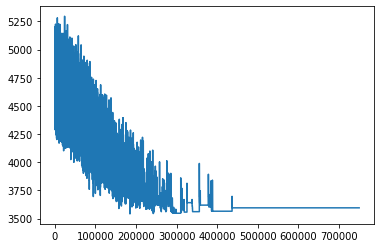

In [109]:
n,A,B = read_qap(name='nug24')
goal = 3488 
opt_solution = (17,8,11,23,4,20,15,19,22,18,3,14,1,10,7,9,16,21,24,12,6,13,5,2)
costs,p = simulated_annealing2(n,A,B,T=750000,radius=1,alpha=0.2)
plt.figure()
plt.plot(costs)
plt.show()

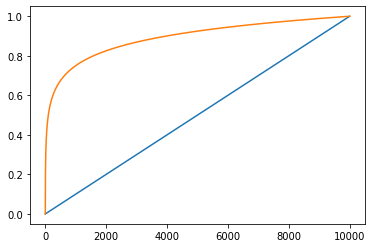

In [24]:
T = 10000
plt.plot([t/T for t in range(T)])
plt.plot([np.log(t)/np.log(T) for t in range(1,T)])

In [25]:
def simulated_annealing3(n,A,B,T=500000,radius=1,alpha=1.0):
    t0 = time.time()

    p = np.random.permutation(n)
    p_cost = qap_objective_function(p,n,A,B)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q,n,A,B)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        # T function
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * np.log(t)/np.log(T))):
            p, p_cost = q, q_cost
        costs[t] = p_cost

    print(time.time() - t0, costs.min())
    return costs,p

Problem size: 24
Flow matrix:
 [[0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 7. 3. 4. 5. 6. 7. 8.]
 [1. 0. 1. 2. 3. 4. 2. 1. 2. 3. 4. 5. 3. 2. 3. 4. 5. 6. 4. 3. 4. 5. 6. 7.]
 [2. 1. 0. 1. 2. 3. 3. 2. 1. 2. 3. 4. 4. 3. 2. 3. 4. 5. 5. 4. 3. 4. 5. 6.]
 [3. 2. 1. 0. 1. 2. 4. 3. 2. 1. 2. 3. 5. 4. 3. 2. 3. 4. 6. 5. 4. 3. 4. 5.]
 [4. 3. 2. 1. 0. 1. 5. 4. 3. 2. 1. 2. 6. 5. 4. 3. 2. 3. 7. 6. 5. 4. 3. 4.]
 [5. 4. 3. 2. 1. 0. 6. 5. 4. 3. 2. 1. 7. 6. 5. 4. 3. 2. 8. 7. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 7.]
 [2. 1. 2. 3. 4. 5. 1. 0. 1. 2. 3. 4. 2. 1. 2. 3. 4. 5. 3. 2. 3. 4. 5. 6.]
 [3. 2. 1. 2. 3. 4. 2. 1. 0. 1. 2. 3. 3. 2. 1. 2. 3. 4. 4. 3. 2. 3. 4. 5.]
 [4. 3. 2. 1. 2. 3. 3. 2. 1. 0. 1. 2. 4. 3. 2. 1. 2. 3. 5. 4. 3. 2. 3. 4.]
 [5. 4. 3. 2. 1. 2. 4. 3. 2. 1. 0. 1. 5. 4. 3. 2. 1. 2. 6. 5. 4. 3. 2. 3.]
 [6. 5. 4. 3. 2. 1. 5. 4. 3. 2. 1. 0. 6. 5. 4. 3. 2. 1. 7. 6. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 7. 1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5

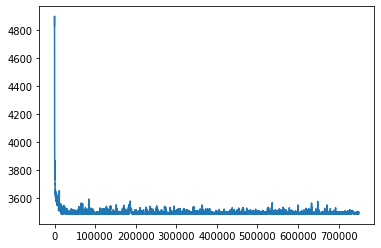

In [27]:
n,A,B = read_qap(name='nug24')
goal = 3488 
opt_solution = (17,8,11,23,4,20,15,19,22,18,3,14,1,10,7,9,16,21,24,12,6,13,5,2)
costs,p = simulated_annealing3(n,A,B,T=750000,radius=1,alpha=0.2)
plt.figure()
plt.plot(costs)
plt.show()

## P2
a) Zaimplementuj algorytm PBIL.

In [2]:
def OneMax(P):
    return P.sum(axis=1)

In [3]:
def DeceptiveOneMax(P):
    N, K = P.shape
    s = P.sum(axis=1)
    s[s==0] = K+1
    return s

In [4]:
def KDeceptiveOneMax(P, k=5):
    N, K = P.shape
    s = np.zeros(N,dtype=np.int)
    for a in range(k,K+1,k):
        act = P[:,a-k:a].sum(axis=1)
        act[act==0] = k+1
        s+=act
    return s

In [5]:
def random_population(P,N,K):
    return np.random.rand(N, K) < P

In [6]:
def PBIL(K,F,N,theta1,thet2,theta3,T=1000):
    p = np.ones(K)/2
    population = random_population(p,N,K)
    scores = F(population)
    history_best = []
    history_worst = []
    history_mean = []
    history_p = []
    for t in tqdm(range(T), desc='PBIL', position=0):
        i = np.argmax(scores)
        if t and not t%100:
            print(f't: {t}, max score: {scores[i]}')
        history_best.append(np.max(scores))
        history_worst.append(np.min(scores))
        history_mean.append(np.mean(scores))
        history_p.append(p)
        best_v = population[i]
        p = (1-theta1)*p + best_v*theta1
        p = np.minimum(p,1)
        p = np.maximum(p,0)
        if_explore = np.random.choice([0,1],size=(K,),p=(1-thet2,thet2))
        how_explore = np.random.choice([0,1],size=(K,))
        p = p * (1-if_explore) + (p * (1-theta3) + how_explore * theta3) * if_explore
        population = random_population(p,N,K)
        scores = F(population)
    print(f'Final score: {scores[i]}')
    return best_v, scores[i], p, history_best, history_worst, history_mean, history_p

In [7]:
res,score,p,best,worst,mean,ps = PBIL(1000,OneMax,100,0.05,0.01,0.05,T=1000)

t: 100, max score: 717
t: 200, max score: 843
t: 300, max score: 924
t: 400, max score: 970
t: 500, max score: 991
t: 600, max score: 997
t: 700, max score: 999
t: 800, max score: 1000
t: 900, max score: 999
Final score: 996


In [7]:
def plot_model(best,mean,worst,ps):
    f,(axs1,axs2) = plt.subplots(1,2,figsize=(15,5))
    axs1.plot(best, label='Best')
    axs1.plot(mean, label='Mean')
    axs1.plot(worst, label='Worst')
    axs1.set_title('Model accuracy over time')
    axs1.legend()
    axs2.plot(ps)
    axs2.set_title('Probabilities')
    plt.show()

OneMax, K=1000, N=100, T=1000

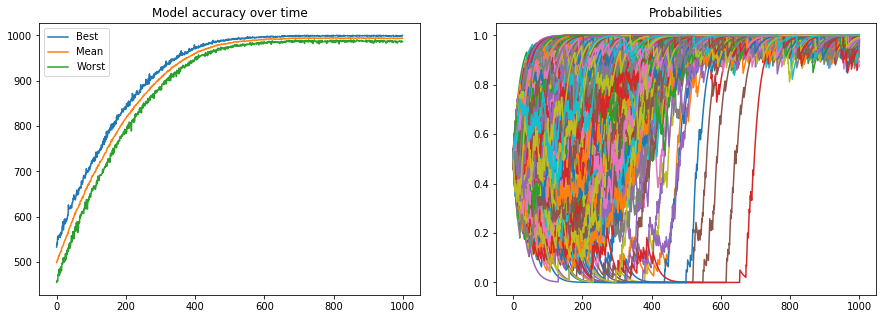

In [27]:
plot_model(best,mean,worst,ps)

t: 100, max score: 696
t: 200, max score: 806
t: 300, max score: 853
t: 400, max score: 889
t: 500, max score: 913
t: 600, max score: 920
t: 700, max score: 922
t: 800, max score: 930
t: 900, max score: 929
Final score: 914


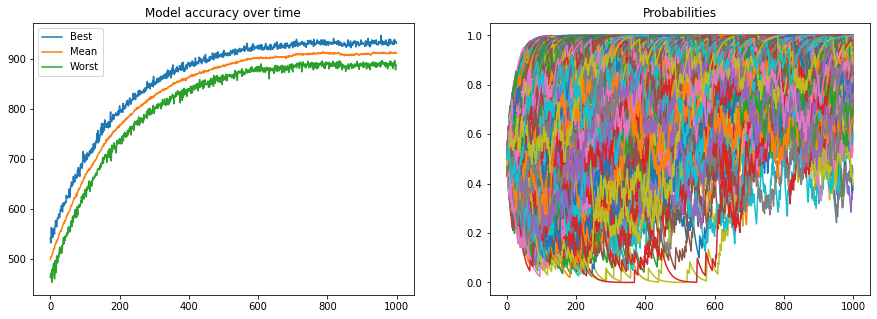

In [28]:
res,score,p,best,worst,mean,ps = PBIL(1000,OneMax,100,0.05,0.05,0.05,T=1000)
plot_model(best,mean,worst,ps)

t: 100, max score: 706
t: 200, max score: 840
t: 300, max score: 941
t: 400, max score: 985
t: 500, max score: 988
t: 600, max score: 989
t: 700, max score: 991
t: 800, max score: 991
t: 900, max score: 992
Final score: 992


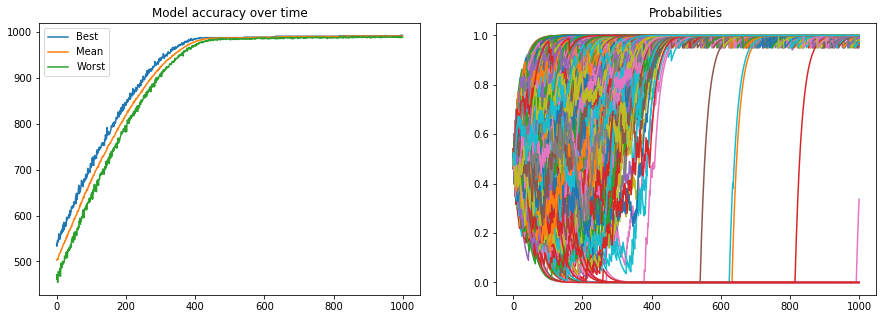

In [29]:
res,score,p,best,worst,mean,ps = PBIL(1000,OneMax,100,0.05,0.001,0.05,T=1000)
plot_model(best,mean,worst,ps)

t: 100, max score: 593
t: 200, max score: 611
t: 300, max score: 652
t: 400, max score: 685
t: 500, max score: 703
t: 600, max score: 733
t: 700, max score: 748
t: 800, max score: 777
t: 900, max score: 802
Final score: 792


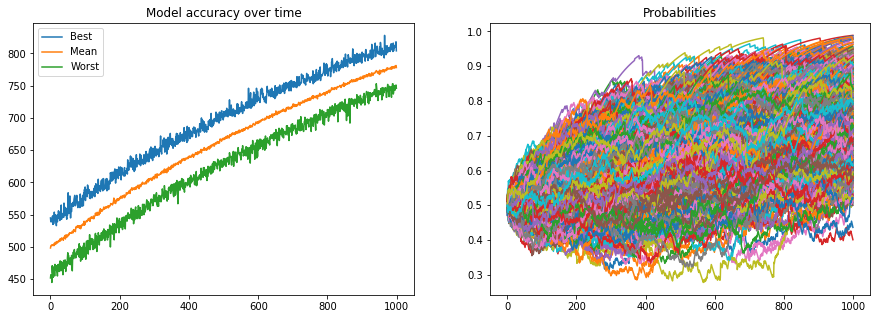

In [32]:
res,score,p,best,worst,mean,ps = PBIL(1000,OneMax,100,0.01,0.01,0.05,T=1000)
plot_model(best,mean,worst,ps)

DeceptiveOneMax K=1000, N=100, T=1000

t: 100, max score: 705
t: 200, max score: 786
t: 300, max score: 859
t: 400, max score: 886
t: 500, max score: 907
t: 600, max score: 917
t: 700, max score: 928
t: 800, max score: 925
t: 900, max score: 936
Final score: 915


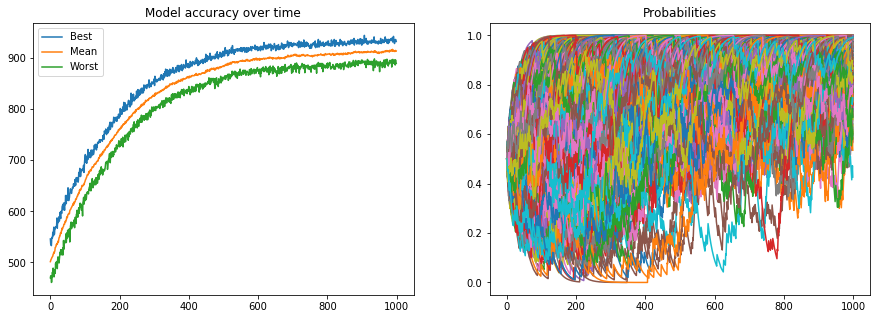

In [34]:
res,score,p,best,worst,mean,ps = PBIL(1000,DeceptiveOneMax,100,0.05,0.05,0.05,T=1000)
plot_model(best,mean,worst,ps)

t: 100, max score: 719
t: 200, max score: 857
t: 300, max score: 938
t: 400, max score: 983
t: 500, max score: 993
t: 600, max score: 995
t: 700, max score: 996
t: 800, max score: 996
t: 900, max score: 997
Final score: 993


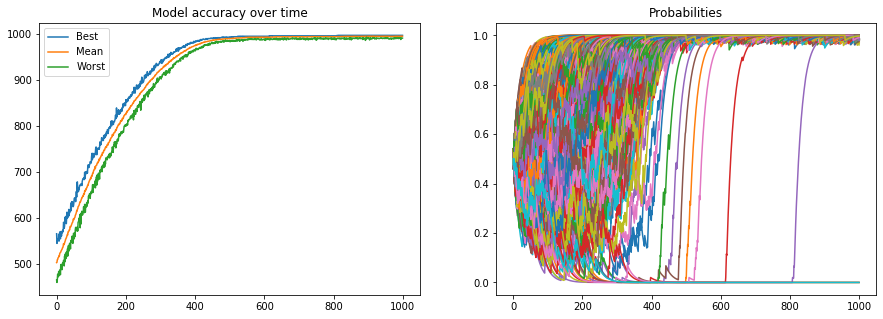

In [33]:
res,score,p,best,worst,mean,ps = PBIL(1000,DeceptiveOneMax,100,0.05,0.01,0.02,T=1000)
plot_model(best,mean,worst,ps)

t: 100, max score: 695
t: 200, max score: 752
t: 300, max score: 804
t: 400, max score: 801
t: 500, max score: 804
t: 600, max score: 823
t: 700, max score: 820
t: 800, max score: 822
t: 900, max score: 826
Final score: 789


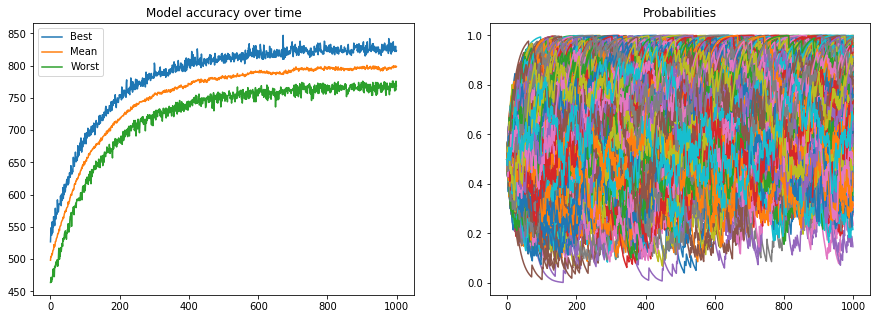

In [35]:
res,score,p,best,worst,mean,ps = PBIL(1000,DeceptiveOneMax,100,0.05,0.1,0.05,T=1000)
plot_model(best,mean,worst,ps)

t: 100, max score: 618
t: 200, max score: 627
t: 300, max score: 618
t: 400, max score: 631
t: 500, max score: 621
t: 600, max score: 629
t: 700, max score: 627
t: 800, max score: 628
t: 900, max score: 618
Final score: 589


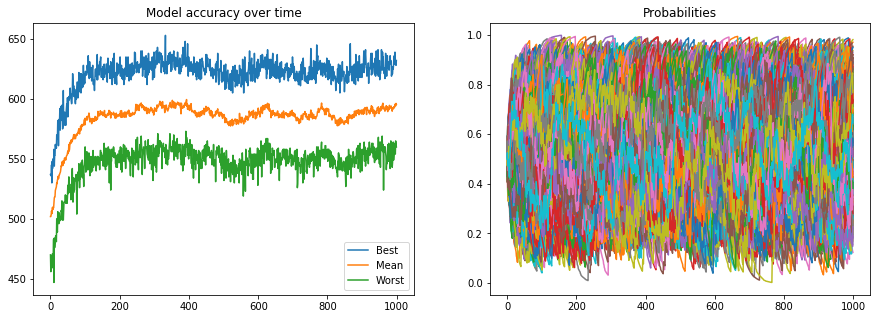

In [36]:
res,score,p,best,worst,mean,ps = PBIL(1000,DeceptiveOneMax,100,0.05,0.2,0.1,T=1000)
plot_model(best,mean,worst,ps)

K-DeceptiveOneMax K=1000, N=100, T=1000

t: 100, max score: 668
t: 200, max score: 741
t: 300, max score: 804
t: 400, max score: 852
t: 500, max score: 889
t: 600, max score: 911
t: 700, max score: 915
t: 800, max score: 929
t: 900, max score: 934
Final score: 903


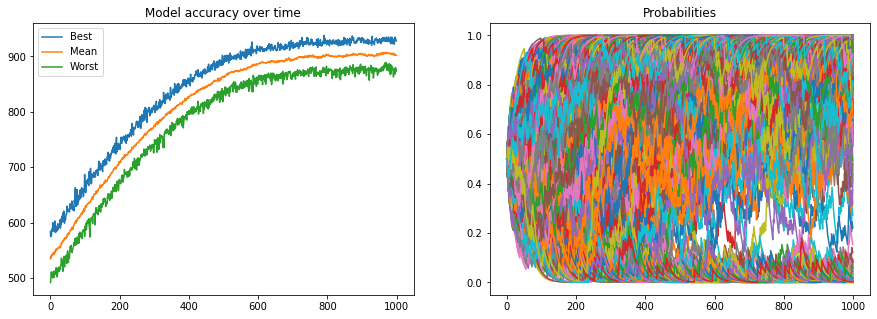

In [39]:
res,score,p,best,worst,mean,ps = PBIL(1000,KDeceptiveOneMax,100,0.05,0.05,0.05,T=1000)
plot_model(best,mean,worst,ps)

t: 100, max score: 663
t: 200, max score: 777
t: 300, max score: 883
t: 400, max score: 959
t: 500, max score: 995
t: 600, max score: 1002
t: 700, max score: 1010
t: 800, max score: 1012
t: 900, max score: 1012
Final score: 1012


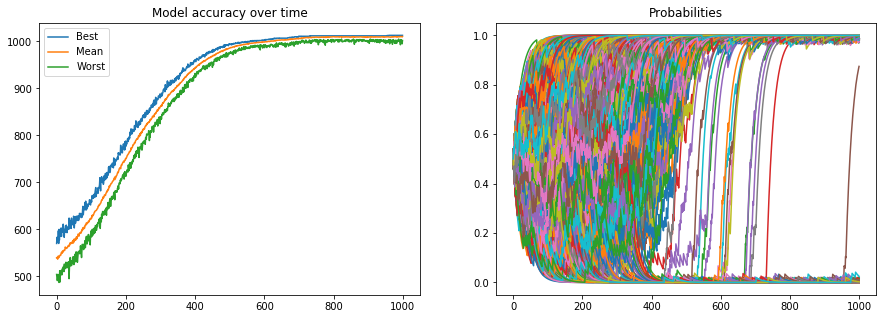

In [40]:
res,score,p,best,worst,mean,ps = PBIL(1000,KDeceptiveOneMax,100,0.05,0.01,0.02,T=1000)
plot_model(best,mean,worst,ps)

t: 100, max score: 693
t: 200, max score: 805
t: 300, max score: 910
t: 400, max score: 970
t: 500, max score: 990
t: 600, max score: 999
t: 700, max score: 1005
t: 800, max score: 1008
t: 900, max score: 1008
t: 1000, max score: 1009
t: 1100, max score: 1011
t: 1200, max score: 1012
t: 1300, max score: 1012
t: 1400, max score: 1013
t: 1500, max score: 1013
t: 1600, max score: 1013
t: 1700, max score: 1013
t: 1800, max score: 1014
t: 1900, max score: 1014
Final score: 1013


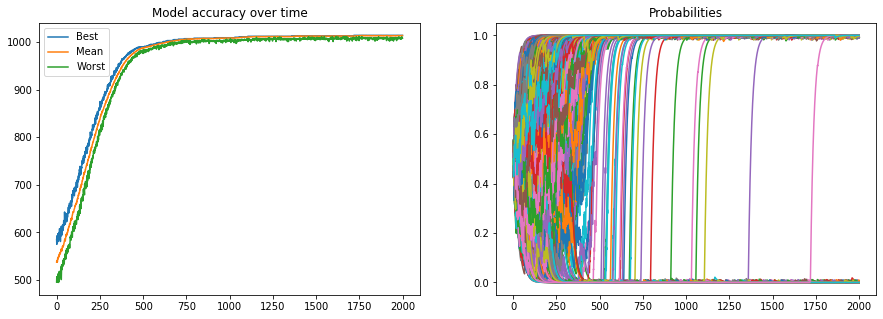

In [41]:
res,score,p,best,worst,mean,ps = PBIL(1000,KDeceptiveOneMax,100,0.05,0.005,0.01,T=2000)
plot_model(best,mean,worst,ps)

t: 100, max score: 671
t: 200, max score: 801
t: 300, max score: 900
t: 400, max score: 958
t: 500, max score: 992
t: 600, max score: 1003
t: 700, max score: 1009
t: 800, max score: 1011
t: 900, max score: 1015
t: 1000, max score: 1014
t: 1100, max score: 1015
t: 1200, max score: 1013
t: 1300, max score: 1014
t: 1400, max score: 1014
t: 1500, max score: 1015
t: 1600, max score: 1015
t: 1700, max score: 1015
t: 1800, max score: 1015
t: 1900, max score: 1014
Final score: 1008


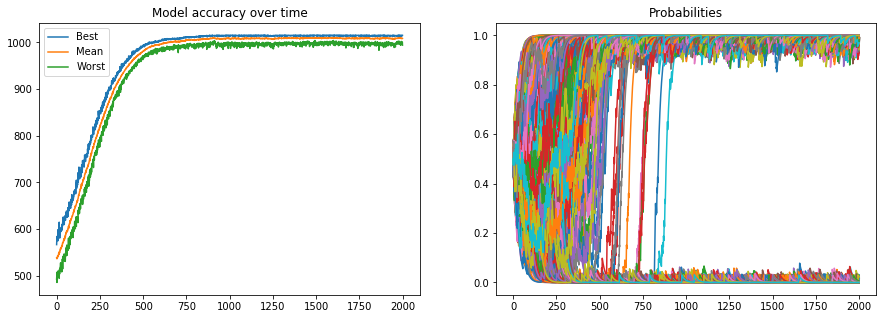

In [42]:
res,score,p,best,worst,mean,ps = PBIL(1000,KDeceptiveOneMax,100,0.05,0.015,0.03,T=2000)
plot_model(best,mean,worst,ps)

K-DeceptiveOneMax K=100, N=100, T=1000

t: 100, max score: 97
t: 200, max score: 101
t: 300, max score: 101
t: 400, max score: 101
t: 500, max score: 101
t: 600, max score: 101
t: 700, max score: 101
t: 800, max score: 101
t: 900, max score: 101
t: 1000, max score: 101
t: 1100, max score: 101
t: 1200, max score: 101
t: 1300, max score: 101
t: 1400, max score: 101
t: 1500, max score: 101
t: 1600, max score: 101
t: 1700, max score: 101
t: 1800, max score: 101
t: 1900, max score: 101
Final score: 101


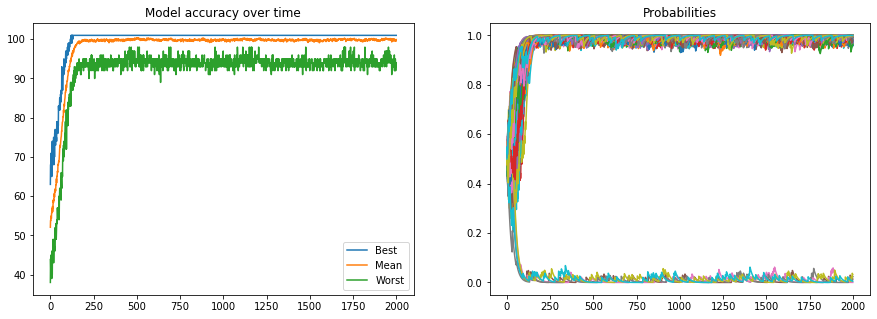

In [52]:
res,score,p,best,worst,mean,ps = PBIL(100,KDeceptiveOneMax,100,0.05,0.05,0.02,T=2000)
plot_model(best,mean,worst,ps)

K-DeceptiveOneMax K=10, N=100, T=1000

t: 100, max score: 10
t: 200, max score: 11
t: 300, max score: 12
t: 400, max score: 12
t: 500, max score: 12
t: 600, max score: 12
t: 700, max score: 12
t: 800, max score: 12
t: 900, max score: 12
t: 1000, max score: 12
t: 1100, max score: 12
t: 1200, max score: 12
t: 1300, max score: 12
t: 1400, max score: 12
t: 1500, max score: 12
t: 1600, max score: 12
t: 1700, max score: 12
t: 1800, max score: 12
t: 1900, max score: 12
Final score: 5


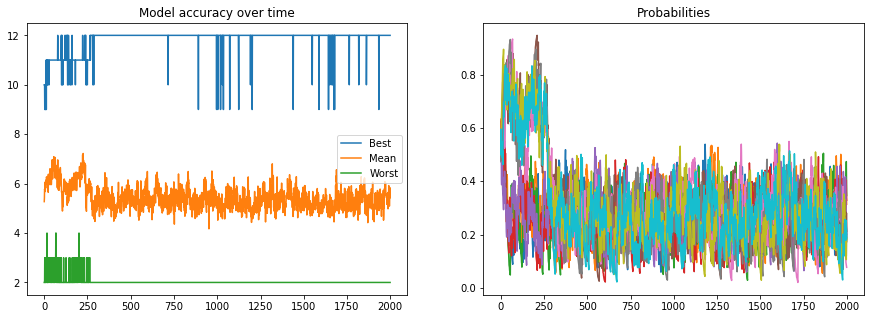

In [59]:
res,score,p,best,worst,mean,ps = PBIL(10,KDeceptiveOneMax,100,0.05,0.5,0.1,T=2000)
plot_model(best,mean,worst,ps)

## P3
Zastosuj algorytm PBIL do rozwiązywania uproszczonego problemu klasyfikacji wielospektralnych obrazów satelitarnych w następujący sposób:

Dany jest obraz wielospektralny o 3 spektrach i rozmiarze 106 x 148 punktów (zapisany w formacie BSQ, pliki ImageRaw.bsq i ImageRaw.hdr). Każdy punkt obrazu można przedstawić jako wektor rozmiaru 3 x 1, a więc cały obraz można przedstawić jako macierz rozmiaru 3 x 15688 (zapisana w pliku ImageRaw.txt). Dana jest wzorcowa klasyfikacja tego obrazu - jest to bitmapa o 11 kolorach i rozmiarze 106 x 148 punktów (zapisana w pliku ImageExpert.bmp). Można przedstawić ją jako wektor rozmiaru 1 x 15688 o wartościach ze zbioru {1, 2, …, 11} (zapisany w pliku ImageExpert.txt).

Interesują nas tylko 3 klasy punktów (klasa nr 3, 7 i 9), pozostałe punkty więc usuwamy z danych,
otrzymując macierz X rozmiaru 3 x 9350 (punkty obrazu wielospektralnego) oraz wektor C rozmiaru 1 x 9350 o wartościach ze zbioru {1, 2, 3} (wzorcowa klasyfikacja). Dane te zapisane są odpowiednio w plikach ImageRawReduced.txt i ImageExpertReduced.txt. 

Dostępnych jest 266 utworzonych wcześniej reguł klasyfikujących. Każda reguła to określona funkcja, która na wejściu dostaje punkt obrazu (wektor rozmiaru 3 x 1), a na wyjściu zwraca etykietę klasy (liczbę ze zbioru {1, 2, 3}). Dla wygody dostępne są już policzone wartości każdej reguły klasyfikującej dla każdego punktu obrazu, a nie same definicje tych reguł (plik ClassificationRules.txt).

Klasyfikacja oparta na pojedynczej regule klasyfikującej nie daje dobrych wyników, podobnie jak i
klasyfikacja oparta na wszystkich 266 regułach klasyfikujących ("większością głosów”). Dobre wyniki
natomiast uzyskuje się, jeśli najpierw wybierze się pewien podzbiór zbioru wszystkich reguł klasyfikujących, a później opiera się decyzję na "większości głosów” reguł z tego podzbioru. 

Do wyznaczenia takiego podzbioru użyj algorytmu PBIL. Przestrzenią poszukiwań będzie zbiór wszystkich wektorów binarnych długości d = 266 (kolejne pozycje odpowiadają kolejnym regułom klasyfikującym: 1 oznacza włączenie, a 0 nie włączanie danej reguły do konstruowanego zbioru). Funkcją celu będzie liczba poprawnie poklasyfikowanych punktów obrazu przez klasyfikator oparty na danym podzbiorze reguł klasyfikujących.
    
    
UWAGA 1: Dane zapisane w plikach wymienionych w drugim akapicie nie są potrzebne (można ich
ewentualnie użyć do wizualizacji). Zamiast nich wystarczą przygotowane przeze mnie dane zapisane w
plikach ImageRawReduced.txt i ImageExpertReduced.txt.

UWAGA 2: Obliczenia mogą być czasochłonne (nawet kilka godzin na starszym sprzęcie). Proponuje
używać komputerów z pracowni 110, które mają odpowiednio szybkie procesory i odpowiednio dużo
pamięci.

In [8]:
image = np.loadtxt('ImageRawReduced.txt', dtype=np.int).T
classes = np.loadtxt('ImageExpertReduced.txt', dtype=np.int)
rules = np.loadtxt('ClassificationRules.txt', dtype=np.int)

In [9]:
def goal(P):
    goals = []
    for p in P:
        used_rules = rules[p==1]
        votes = mode(used_rules, axis=0)[0]
        goals.append(np.sum(votes==classes))
    return goals

In [66]:
res,score,p,best,worst,mean,ps = PBIL(266,goal,10,0.05,0.025,0.02,T=500)

PBIL:  20%|██████████████▊                                                           | 100/500 [06:06<19:40,  2.95s/it]

t: 100, max score: 9134


PBIL:  40%|█████████████████████████████▌                                            | 200/500 [11:16<15:07,  3.02s/it]

t: 200, max score: 9160


PBIL:  60%|████████████████████████████████████████████▍                             | 300/500 [16:24<10:27,  3.14s/it]

t: 300, max score: 9170


PBIL:  80%|███████████████████████████████████████████████████████████▏              | 400/500 [21:32<05:02,  3.03s/it]

t: 400, max score: 9173


PBIL: 100%|██████████████████████████████████████████████████████████████████████████| 500/500 [26:38<00:00,  3.20s/it]

Final score: 9122


NameError: name 'plot_model' is not defined

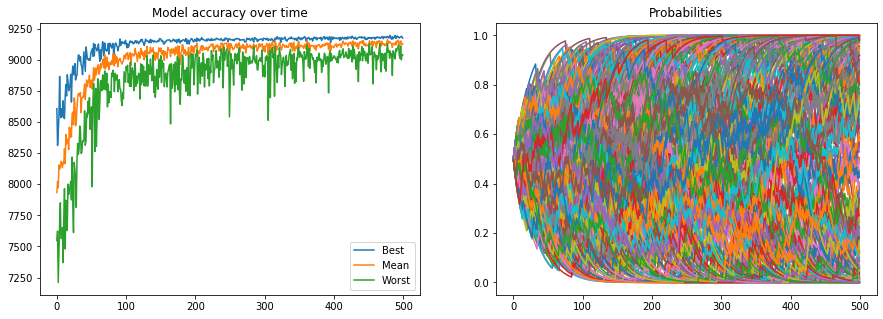

In [68]:
plot_model(best,mean,worst,ps)

PBIL:  10%|███████                                                                | 100/1000 [29:32<3:42:00, 14.80s/it]

t: 100, max score: 9166


PBIL:  20%|██████████████▏                                                        | 200/1000 [56:22<3:43:11, 16.74s/it]

t: 200, max score: 9191


PBIL:  30%|████████████████████▋                                                | 300/1000 [1:23:07<3:00:17, 15.45s/it]

t: 300, max score: 9200


PBIL:  40%|███████████████████████████▌                                         | 400/1000 [1:49:37<2:36:38, 15.66s/it]

t: 400, max score: 9212


PBIL:  50%|██████████████████████████████████▌                                  | 500/1000 [2:16:42<2:10:21, 15.64s/it]

t: 500, max score: 9210


PBIL:  60%|█████████████████████████████████████████▍                           | 600/1000 [2:44:11<1:59:56, 17.99s/it]

t: 600, max score: 9210


PBIL:  70%|████████████████████████████████████████████████▎                    | 700/1000 [3:11:09<1:29:05, 17.82s/it]

t: 700, max score: 9219


PBIL:  80%|███████████████████████████████████████████████████████▏             | 800/1000 [3:41:20<1:01:27, 18.44s/it]

t: 800, max score: 9221


PBIL:  90%|███████████████████████████████████████████████████████████████▉       | 900/1000 [4:11:50<30:16, 18.16s/it]

t: 900, max score: 9224


PBIL: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [4:42:21<00:00, 16.94s/it]


Final score: 9136


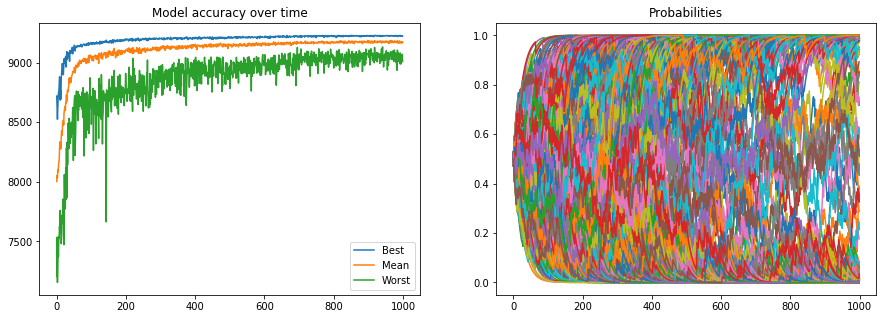

In [10]:
res,score,p,best,worst,mean,ps = PBIL(266,goal,50,0.05,0.02,0.02,T=1000)
plot_model(best,mean,worst,ps)